# hilbert-genome-cooler

#### Overview

We create a Python package called `hilbertgenome` to generate a multiscale `mcool` file of Hilbert curve data. 

This package in turn uses the Python `numpy-hilbert-curve` (`hilbert`) and `cooler` packages.

Each scale of the `mcool` file is derived from **integer-keyed categorical data** (e.g., chromatin states or DHS components) at each Hilbert curve order, and put into its own `cool` file.

The set of `cool` files — each at its own "resolution" to represent Hilbert curve order — can then be loaded into a final `mcool` file.

#### Notes

1. This does not yet look at using HiGlass to render this `mcool` file; customization of the 2D track type will be required for presenting categorical data, similar to what was required for using HiGlass to render chromatin state or DHS component "tornado" multivec tracks. 

In [1]:
# The following directive activates inline plotting
%matplotlib inline

In [2]:
%%bash

pip install h5py
pip install cooler
pip install natsort
pip install matplotlib
pip install numpy-hilbert-curve

In [3]:
import io
import os
import requests
import hilbertgenome as hg

In [4]:
data_dir = 'hilbert_genome_cooler_data'
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)
mcool_fn = os.path.join(data_dir, 'signal.mcool')
chromsizes_fn = os.path.join(data_dir, 'chromsizes.txt')

In [5]:
#
# ref. /net/seq/data/projects/Epilogos
#          /multivec-for-browser-2022-redo/epilogos_tracks/single/human
#          /Boix_et_al_833_sample/hg19/18/All_833_biosamples/S1/scores.txt.filledGap.versionSorted.txt.gz
#
signal_categories = 18
signal_resolution = 200
signal_remote_URI = 'https://resources.altius.org/~areynolds/public/Boix_et_al_833_sample.hg19.18.All_833_biosamples.S1.scores.txt.gz'
signal_local_fn = os.path.join(data_dir, 'Boix_et_al_833_sample.hg19.18.All_833_biosamples.S1.scores.txt.gz')
if not os.path.exists(signal_local_fn):
    try:
        r = requests.get(signal_remote_URI)
        with open(signal_local_fn, "wb") as ofh:
            b = io.BytesIO(r.content)
            ofh.write(b.getbuffer())
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)

In [6]:
curve_order_min = 4
curve_order_max = 12
pseudo_chromosome_name = 'hilbert{}'.format(curve_order_max)

In [7]:
hgo = hg.HilbertGenome(assembly="hg38", 
                       input_signal_fn=signal_local_fn,
                       input_signal_categories=signal_categories,
                       input_signal_resolution=signal_resolution, 
                       curve_order_min=curve_order_min,
                       curve_order_max=curve_order_max,
                       output_mcool_fn=mcool_fn,
                       output_chromsizes_fn=chromsizes_fn,
                       pseudo_chromosome_name=pseudo_chromosome_name)

Note: Processing signal for curve order 12...
Note: Processing signal for curve order 11...
Note: Processing signal for curve order 10...
Note: Processing signal for curve order 9...
Note: Processing signal for curve order 8...
Note: Processing signal for curve order 7...
Note: Processing signal for curve order 6...
Note: Processing signal for curve order 5...
Note: Processing signal for curve order 4...
Note: Creating mcool from cooler files...


In [8]:
hgo.cooler_info_for_curve_order(8)

{'bin-size': 144,
 'bin-type': 'fixed',
 'creation-date': '2022-12-15T19:42:06.386698',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 256,
 'nchroms': 1,
 'nnz': 65536,
 'storage-mode': 'square',
 'sum': 649171}

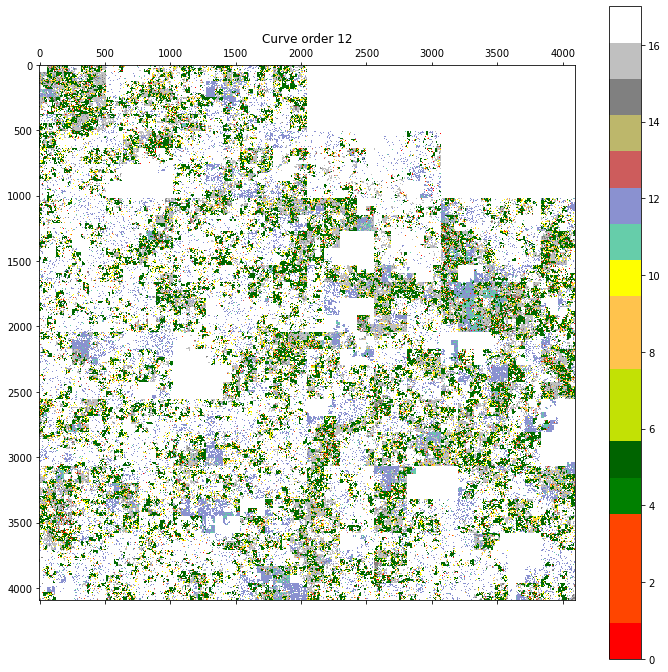

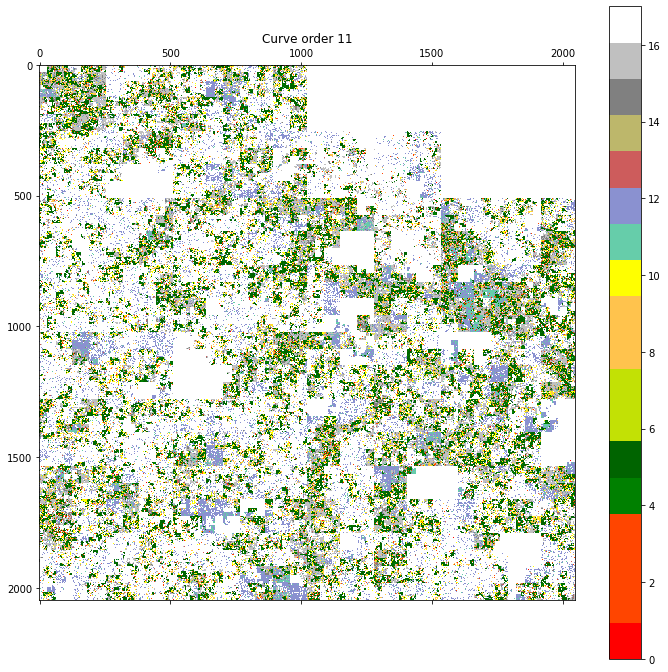

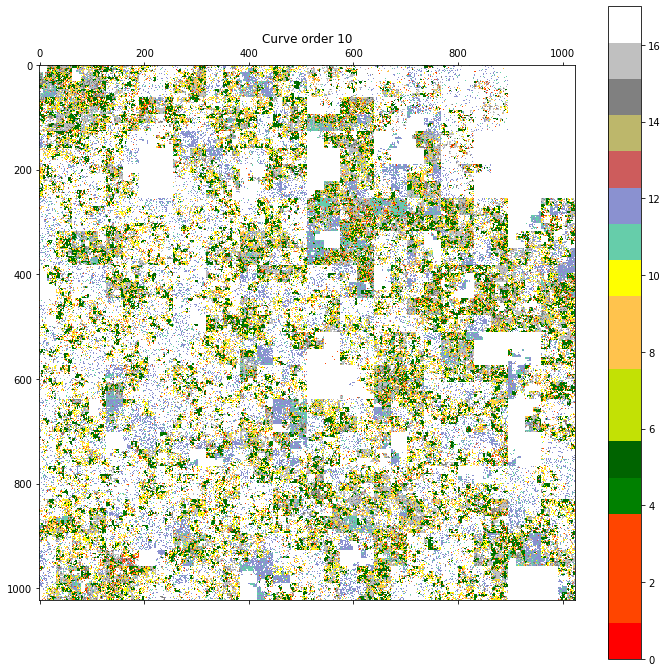

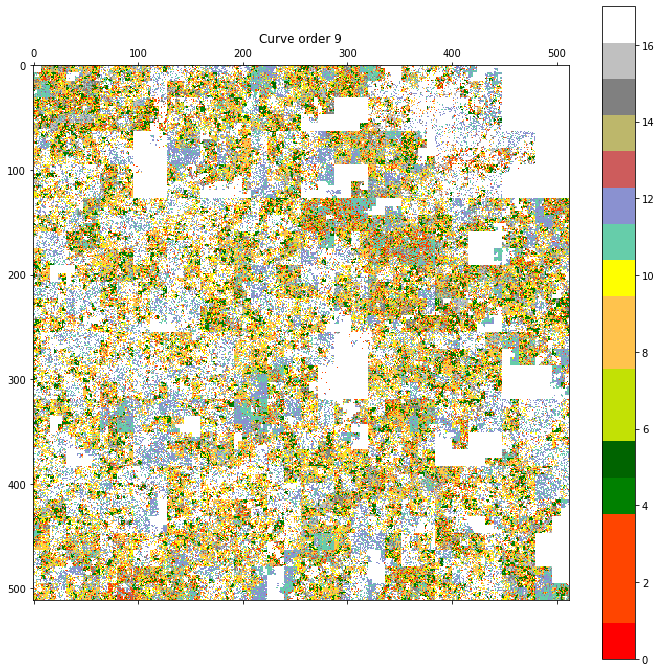

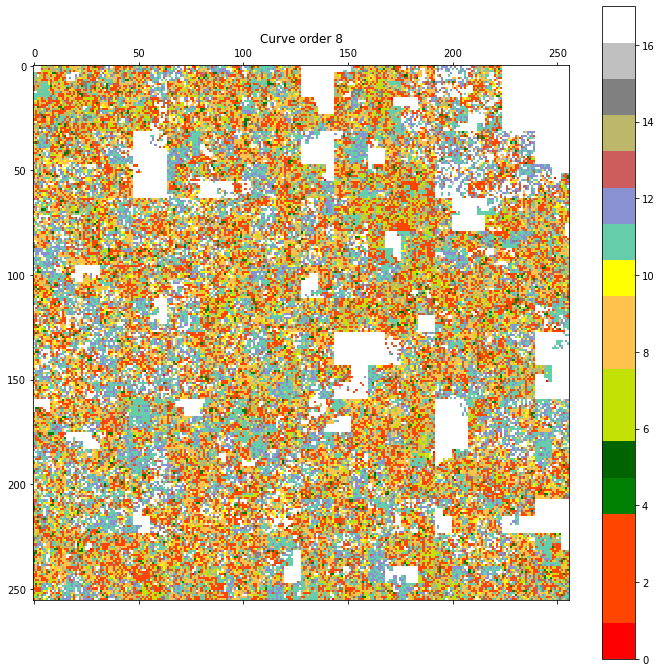

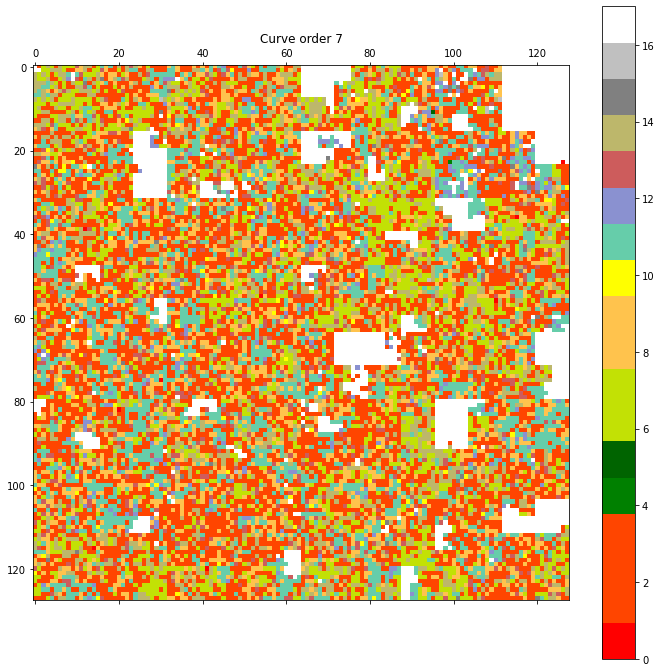

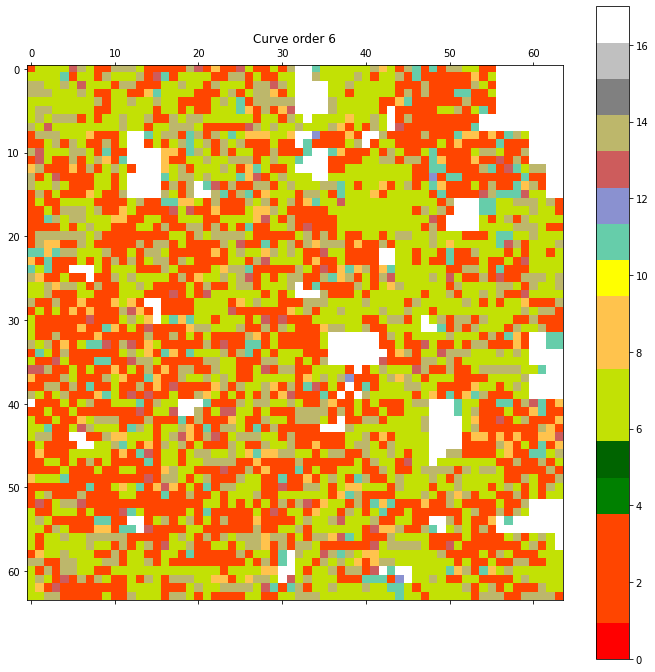

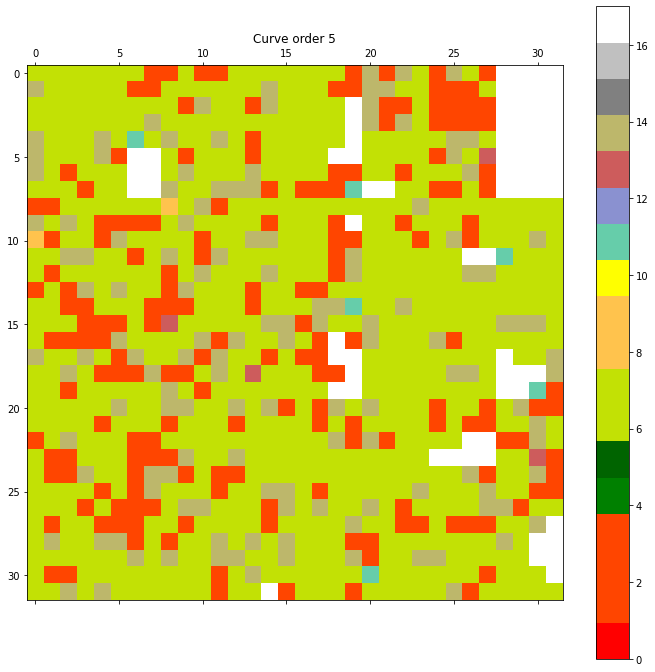

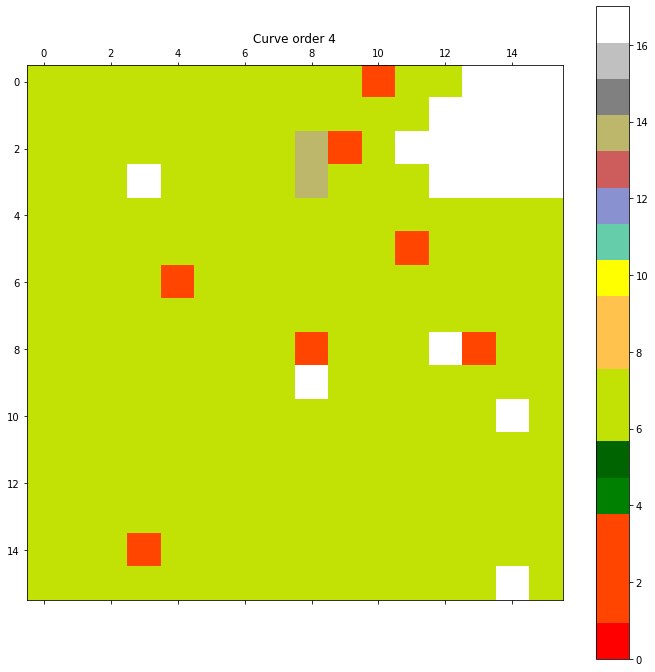

In [9]:
for co in range(curve_order_max, curve_order_min-1, -1):
    hgo.cooler_plot_for_curve_order(co)